# Analizado los crímenes en la Ciudad de Nueva York (Sebastián Rebolledo)

## Hito 1: Aspectos Computacionales

#### En el siguiente trabajo se realizará utilizando una base de datos de la policia de New York y contiene información sobre interrogaciones y detenciones realizadas por ellos. El objetivo es poder reportar la probabilidad de que un sea arrestado o no y predecir si alguna detención terminará en alguna accion violenta.

### Preliminares

- Las metricas que se utilizarán para medir el desempeño de los modelos serán Accuracy, precision y Recall. 
- Se realizará primeramente el analisis de datos perdidos en la base de datos.
- Luego se realizará un preprocesamiento en el vector arstmade .

### Modelos a implementar

- Regresion logistica.

- QuadraticDiscriminantAnalysis.

- Árbol de clasificación, en donde se implementara una grilla para buscar los mejores hiperparametros. A continuacion grilla tentativa.
    - params = {'max_depth':[30,70,150,200], }
    
- GradientBoostingClasifiers : Se implementara una grilla para buscar los mejores hiperparametros. A continuacion grilla tentativa.
    - params = {'learning_rate': [0.01, 0.1, 0.5],'n_estimators': [50, 100, 500, 1000, 2000], 'subsample': [0.1,0.5,0.9]}.
                   
- AdaBoostClassifier: Se implementara una grilla para buscar los mejores hiperparametros. A continuacion grilla tentativa.
     - params = {'learning_rate': [0.01, 0.1, 0.5], 'n_estimators': [50, 100, 500, 1000, 2000]}

In [133]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import mi_modulo as fn
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msngo
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import mean_squared_error, median_absolute_error, r2_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from joblib import dump, load

In [2]:
df = pd.read_csv('2009_1perc.csv').drop('Unnamed: 0', axis=1)

### Analisis de datos perdidos

<AxesSubplot:>

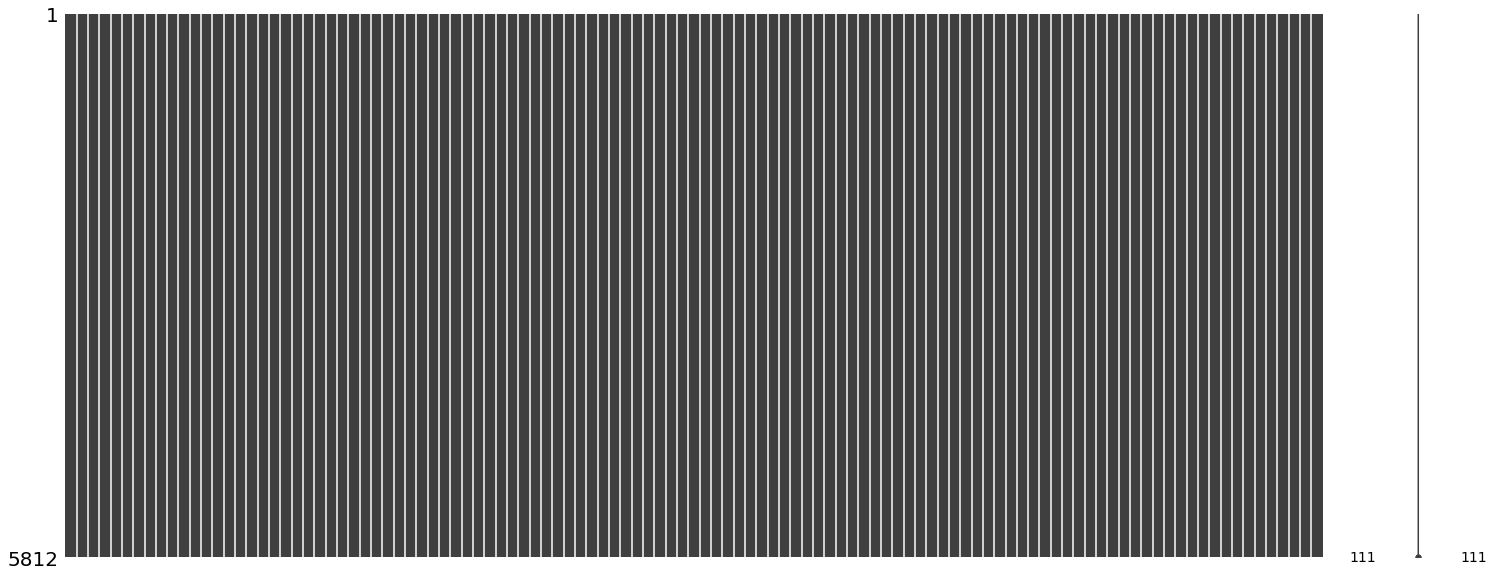

In [3]:
msngo.matrix(df)

In [4]:
df.zip.value_counts()

     5812
Name: zip, dtype: int64

El grafico superior nos indica que no hay valores perdidos, pero observando el dataset nos podemos dar cuenta de que hay columnas que estan en blanco, rellenadas por espacios (' '), lo que genera que el grafico de arriba nos entregue mal la información.
Se recodificarán los espacios (' ') por NaN y se repetirá la busqueda de datos perdidos.

In [5]:
df = fn.ver_datos_perdidos(df)

<AxesSubplot:>

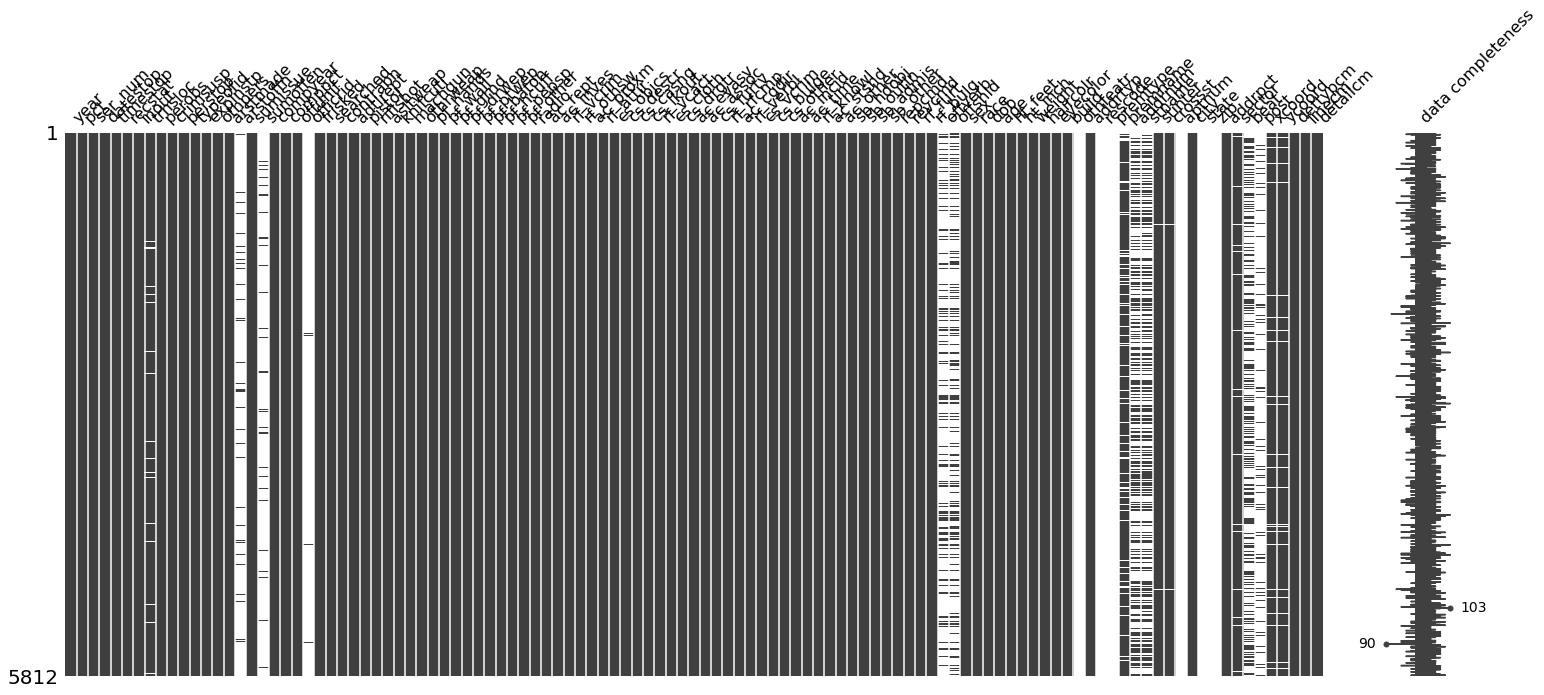

In [6]:
msngo.matrix(df, labels=True)

Se eliminarán las columnas no tienen valores

In [7]:
df=df.drop(['zip','state','city', 'crossst', 'premname','aptnum', 'rescode', 'build', 'premtype', 'othfeatr',
           'officrid', 'sumoffen','post','beat', 'comppct'], axis=1)

<AxesSubplot:>

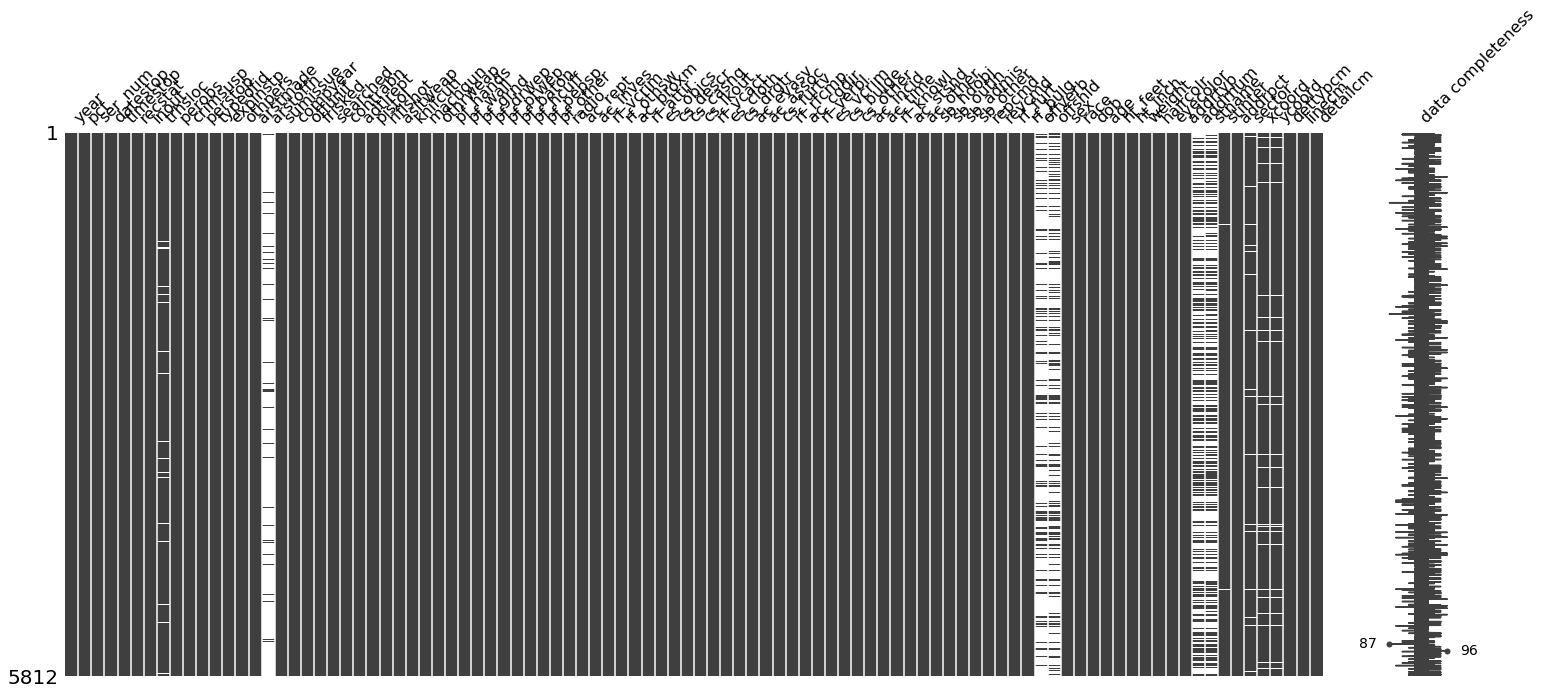

In [8]:
msngo.matrix(df, labels=True)

A continuación se eliminarán las columnas que no sirven para predecir si el procedimiento concluira en arresto, debido a que estas ocurren posterior a la detención y las que le indican al modelo cuando se genero un arresto.

In [9]:
df=df.drop(['offverb', 'offshld','addrnum', 'detailcm','frisked', 'searched', 'contrabn', 'adtlrept',
           'pistol', 'riflshot', 'asltweap', 'knifcuti', 'machgun', 'othrweap', 'offshld','arstoffn','compyear',
           'contrabn', 'linecm','addrtyp', 'crimsusp','dettypcm'], axis=1)

Se refactoriza la columna 'stname', quitando los valores perdidos y agregando la clase 'no registration'

In [10]:
df['stname'] = np.where(df['stname'].isna(), 'no registration', df['stname'])

In [11]:
df['xcoord'] = df['xcoord'].astype('float64')
df['ycoord'] = df['ycoord'].astype('float64')

<AxesSubplot:>

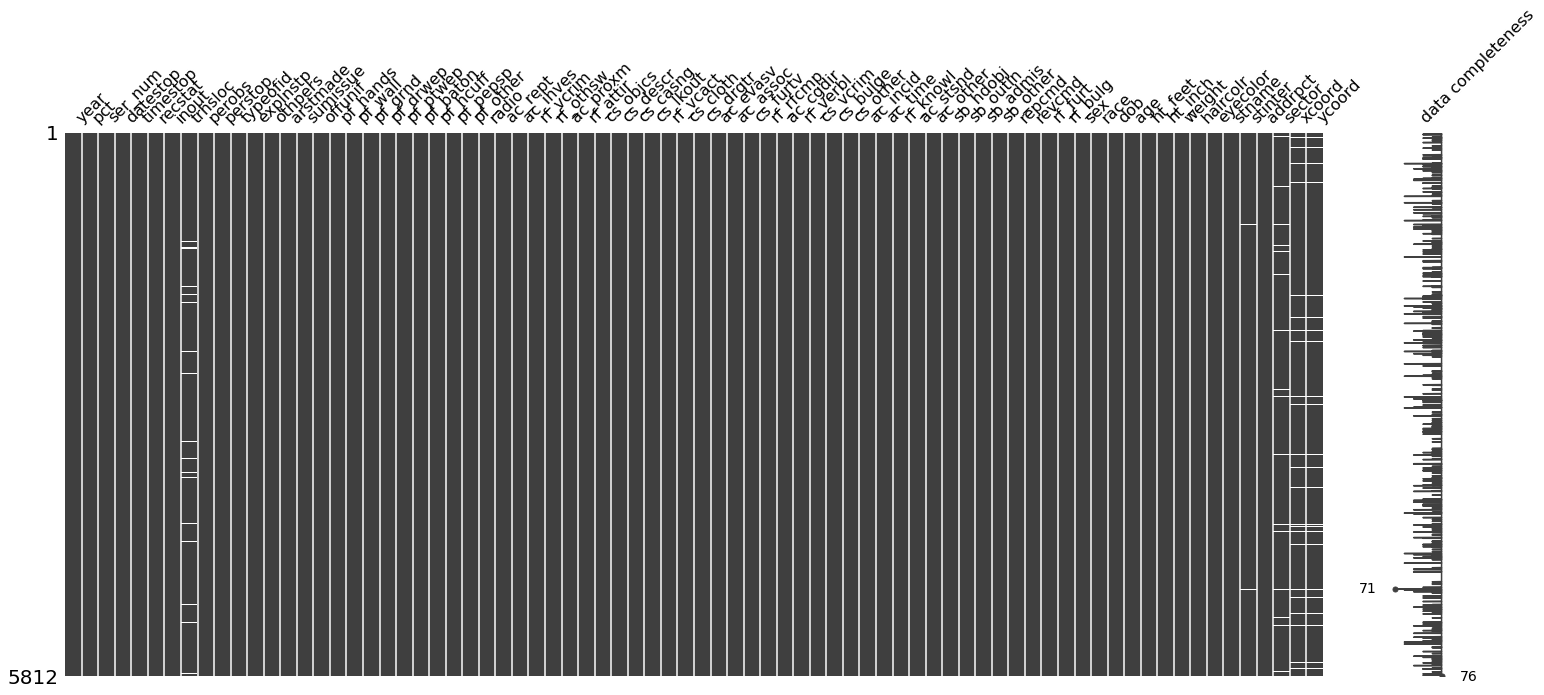

In [12]:
msngo.matrix(df, labels=True)

A continuacion se eliminarán las filas con datos perdidos.

In [13]:
df=df.dropna()

<AxesSubplot:>

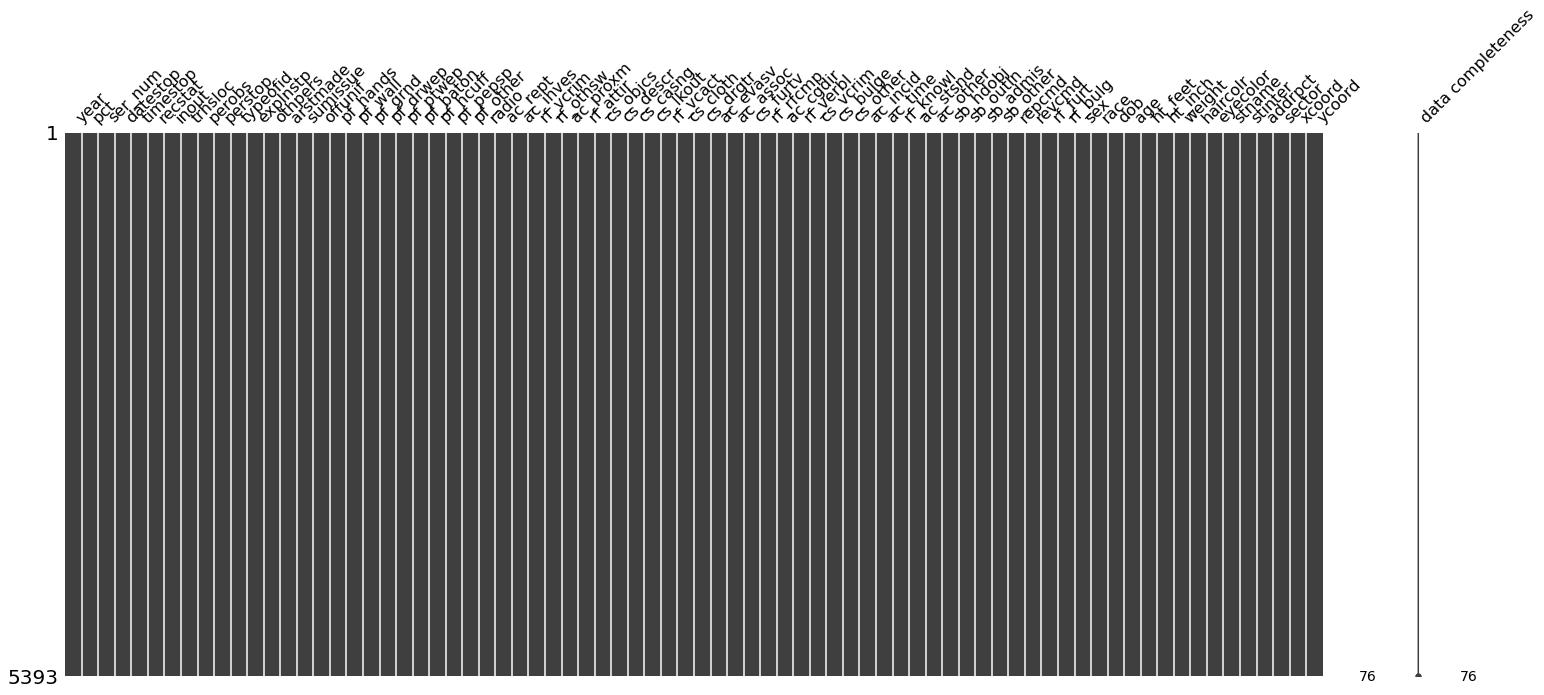

In [14]:
msngo.matrix(df, labels=True)

### Vector objetivo 'arstmade' (Informa si la detención termina en un arresto)

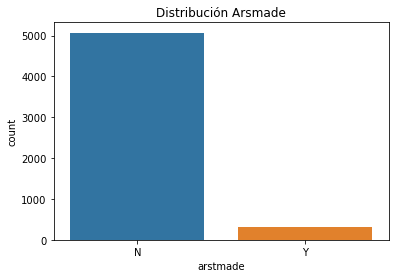

In [15]:
sns.countplot(x='arstmade', data=df)
plt.title('Distribución Arsmade')
plt.show()

Se observa una gran diferencia en la frecuencia entre las clases Yes y No, en donde Yes es la que presenta una menor cantidad. 

## Hito 2: Feature Engineering 

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5393 entries, 0 to 5811
Data columns (total 76 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   year      5393 non-null   float64
 1   pct       5393 non-null   float64
 2   ser_num   5393 non-null   float64
 3   datestop  5393 non-null   float64
 4   timestop  5393 non-null   float64
 5   recstat   5393 non-null   object 
 6   inout     5393 non-null   object 
 7   trhsloc   5393 non-null   object 
 8   perobs    5393 non-null   float64
 9   perstop   5393 non-null   float64
 10  typeofid  5393 non-null   object 
 11  explnstp  5393 non-null   object 
 12  othpers   5393 non-null   object 
 13  arstmade  5393 non-null   object 
 14  sumissue  5393 non-null   object 
 15  offunif   5393 non-null   object 
 16  pf_hands  5393 non-null   object 
 17  pf_wall   5393 non-null   object 
 18  pf_grnd   5393 non-null   object 
 19  pf_drwep  5393 non-null   object 
 20  pf_ptwep  5393 non-null   obje

In [17]:
df.shape

(5393, 76)

In [18]:
df['arstmade'] = np.where(df['arstmade']=='Y', 1,0)

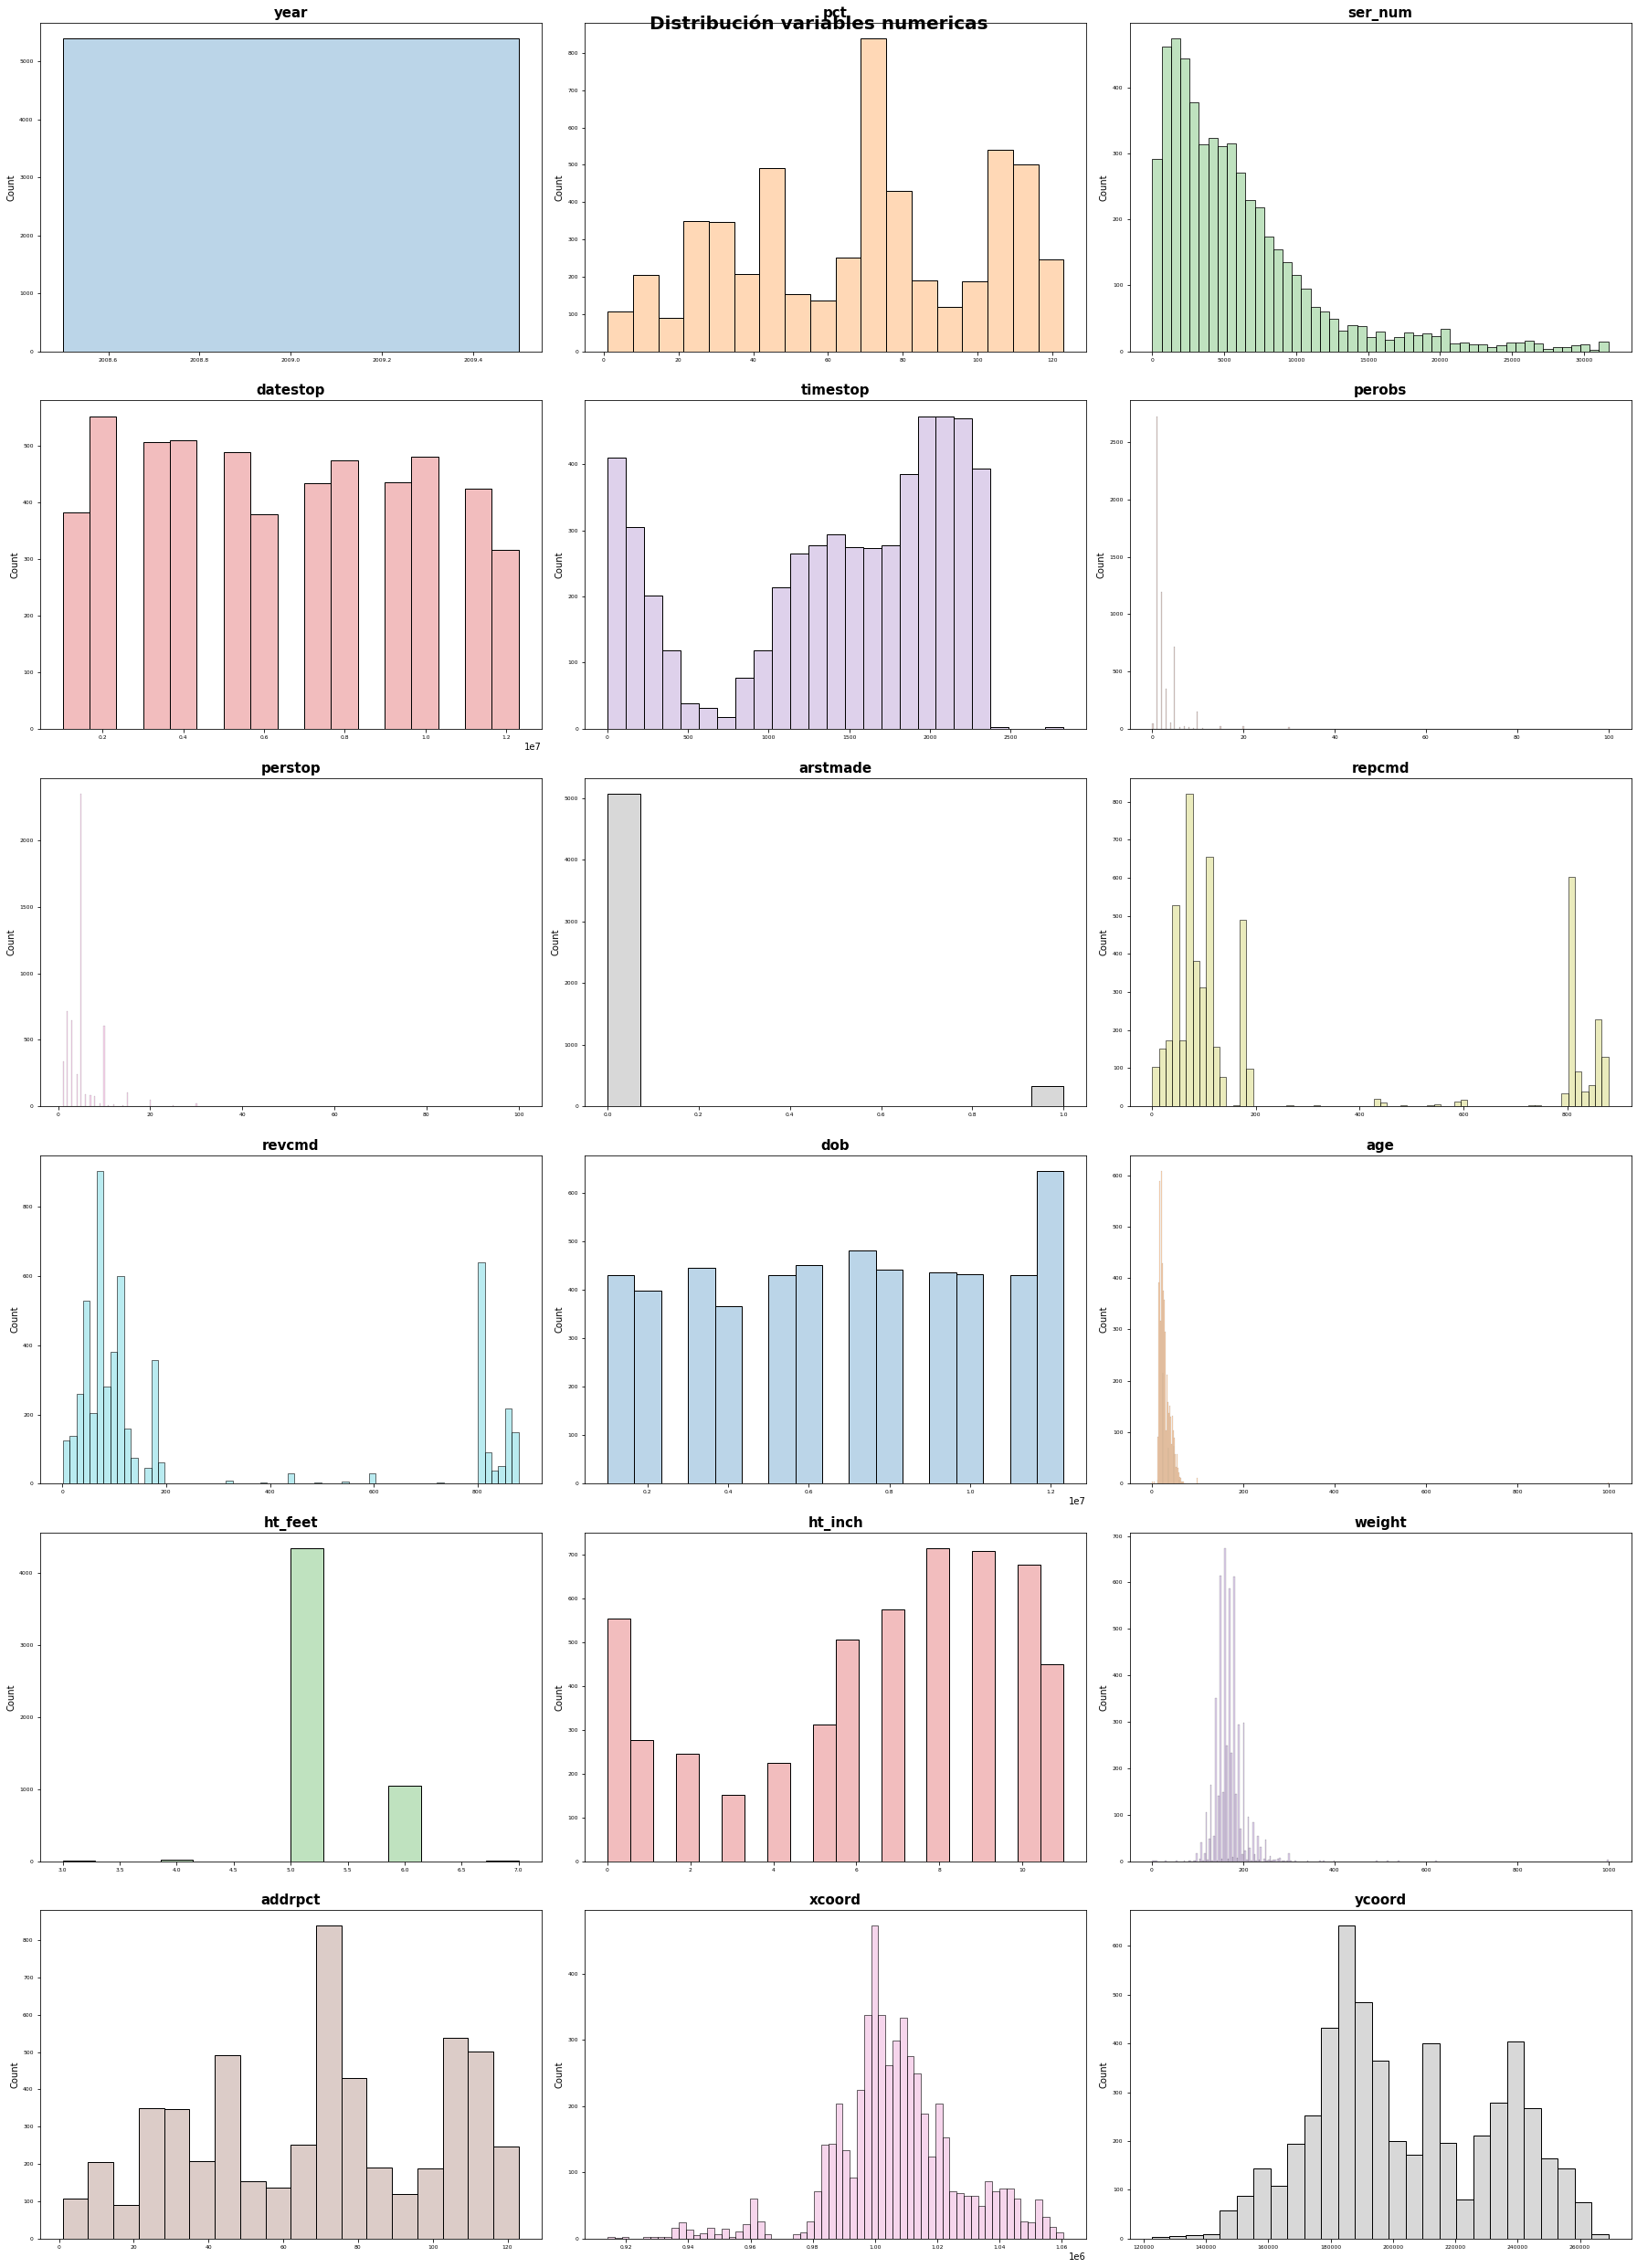

In [19]:
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(25,35))
axes = axes.flat
columnas_numeric = df.select_dtypes(include=['float64', 'int']).columns

for i, colum in enumerate(columnas_numeric):
    sns.histplot(
        data    = df,
        x       = colum,
        stat    = "count",
        color   = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],
        line_kws= {'linewidth': 2},
        alpha   = 0.3,
        ax      = axes[i]
    )
    axes[i].set_title(colum, fontsize = 15, fontweight = "bold")
    axes[i].tick_params(labelsize = 6)
    axes[i].set_xlabel("")
    
plt.subplots_adjust(top = 1.5)   
fig.suptitle('Distribución variables numericas', fontsize = 20, fontweight = "bold");
fig.tight_layout()

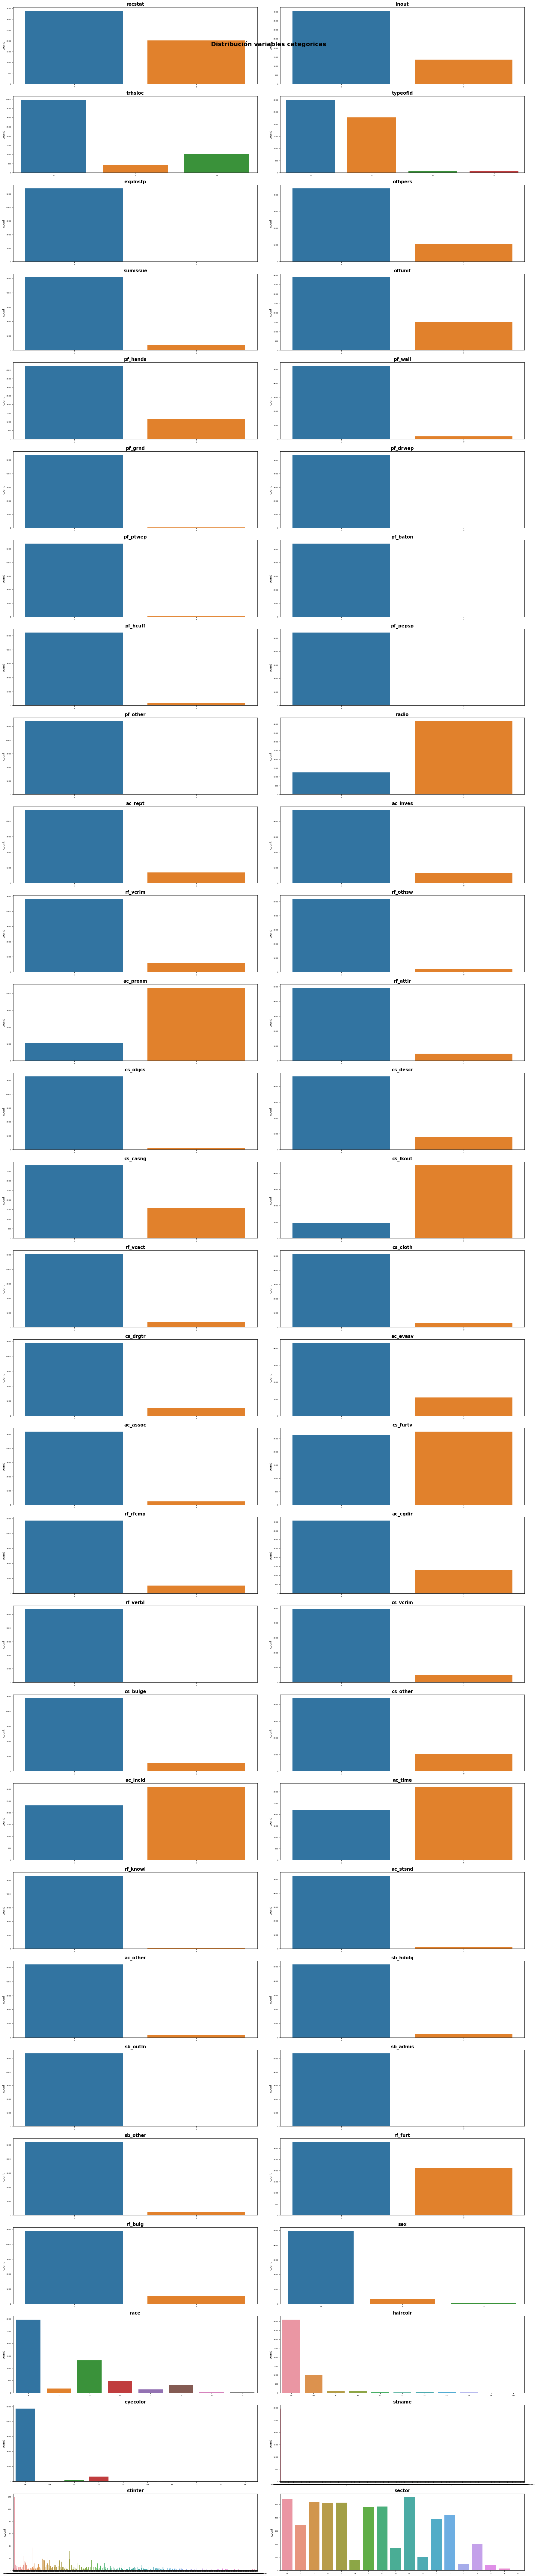

In [20]:
fig, axes = plt.subplots(nrows=29, ncols=2, figsize=(25,120))
axes = axes.flat
columnas_categoricas = df.select_dtypes(include=['object']).columns

for i, colum in enumerate(columnas_categoricas):
    sns.countplot(
        data    = df,
        x       = colum,
        ax      = axes[i]
    )
    axes[i].set_title(colum, fontsize = 15, fontweight = "bold")
    axes[i].tick_params(labelsize = 6)
    axes[i].set_xlabel("")
    
plt.subplots_adjust(top = 2.5)   
fig.suptitle('Distribución variables categoricas', fontsize = 20, fontweight = "bold");
fig.tight_layout()

### Tratamiento de los datos que se utilizarán para validación

In [21]:
df_test = pd.read_csv('2010_1perc.csv').drop('Unnamed: 0', axis=1)

In [22]:
df_test

year  pct  ser_num  datestop  timestop recstat inout trhsloc  perobs  \
0     2010    6      487   1192010      1420       1     O       P       2   
1     2010   42     7138   9042010       225       1     I       T      10   
2     2010   33     2628   6302010      1240       1     I       T       5   
3     2010  108     6384  11172010      2338       1     O       P       3   
4     2010   14     2295   3072010      2240       1     I       T       5   
...    ...  ...      ...       ...       ...     ...   ...     ...     ...   
6008  2010   60     7062   9262010        45       1     O       H       2   
6009  2010   75    15797   7302010        10       A     O       P       1   
6010  2010  123      830   4302010      1630       A     O       P       3   
6011  2010  115    13122  11232010      2100       1     O       P       1   
6012  2010   14      219   1062010      1406       1     I       T       4   

       crimsusp  ...  zip addrpct sector beat post   xcoord  ycoord dettypcm  \
0           FEL  ...            6      G        38   983543  208767       CM   
1        FELONY  ...           42      E            1014172  241737       CM   
2       ROBBERY  ...           33      B    6       1000916  245710       CM   
3          CSCS  ...          108      J            1012612  212240       CM   
4     MISD/ CPW  ...           14      C    7        987636  212439       CM   
...         ...  ...  ...     ...    ...  ...  ...      ...     ...      ...   
6008       MISD  ...           60      I             989382  155162       CM   
6009    ROBBERY  ...           75      A            1012757  186018       CM   
6010        GLA  ...          123      E             933868  138600       CM   
6011     FELONY  ...          115      E            1014722  214388       CM   
6012  CRIM MIS.  ...           14      H   11        987078  215157       CM   

      linecm  detailcm  
0          1        85  
1          1        45  
2          1        85  
3          1        28  
4          1        20  
...      ...       ...  
6008       1        20  
6009       1        85  
6010       1        46  
6011       1        85  
6012       1        23  

[6013 rows x 111 columns]

#### Se realizará la limpieza de los datos de igual manera que se hizo anteriormente para los datos de entrenamiento.

In [23]:
df_test = fn.ver_datos_perdidos(df_test)

In [24]:
df_test=df_test.drop(['zip','state','city', 'crossst', 'premname','aptnum', 'rescode', 'build', 'premtype', 
                      'othfeatr', 'officrid', 'sumoffen','post','beat', 'comppct','offverb', 'offshld','addrnum',
                      'detailcm','frisked', 'searched', 'contrabn', 'adtlrept','pistol', 'riflshot', 'asltweap',
                      'knifcuti', 'machgun', 'othrweap', 'offshld','arstoffn','compyear','contrabn', 'linecm', 
                      'addrtyp', 'crimsusp','dettypcm'], axis=1)

df_test['stname'] = np.where(df_test['stname'].isna(), 'no registration', df_test['stname'])
df_test['xcoord'] = df_test['xcoord'].astype('float64')
df_test['ycoord'] = df_test['ycoord'].astype('float64')
df_test['addrpct'] = df_test['addrpct'].astype('float64')

In [25]:
df_test['arstmade'] = np.where(df_test['arstmade']=='Y', 1,0)

In [26]:
df_test = df_test.dropna()

<AxesSubplot:>

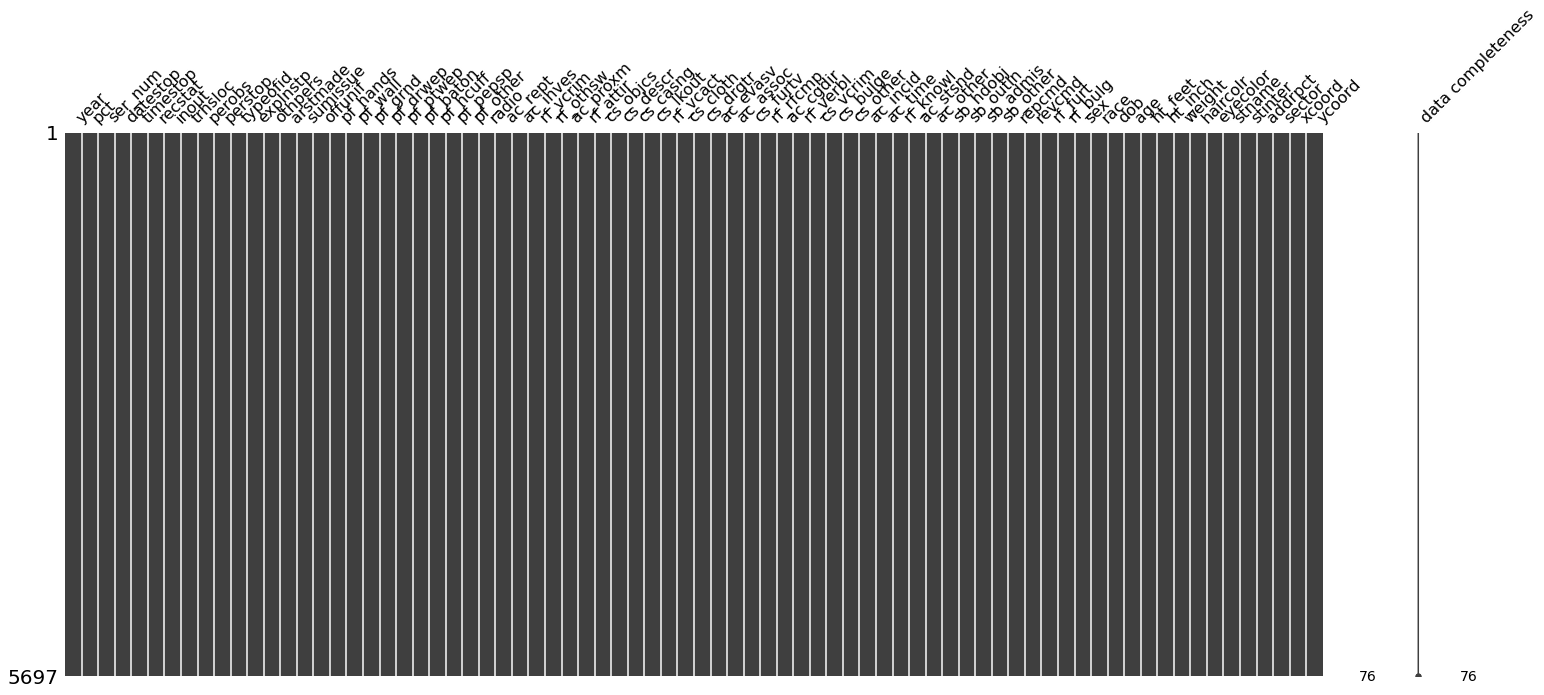

In [27]:
msngo.matrix(df_test, labels=True)

In [28]:
df_test.shape

(5697, 76)

#### A continuación se juntaran los dataframe de 2009 y 2010 para que luego de la binarización ambos tengan la misma cantidad de columnas.

In [29]:
all_data = pd.concat([df, df_test], ignore_index=True)

In [30]:
all_data

year    pct  ser_num    datestop  timestop recstat inout trhsloc  \
0      2009.0   41.0   1779.0   4032009.0     130.0       A     O       P   
1      2009.0  108.0   5805.0  10292009.0    1050.0       A     O       P   
2      2009.0   43.0   8340.0  10062009.0    1450.0       1     O       P   
3      2009.0   77.0    932.0   1232009.0    1843.0       A     O       P   
4      2009.0  110.0  11224.0  12132009.0    1655.0       A     O       P   
...       ...    ...      ...         ...       ...     ...   ...     ...   
11085  2010.0   60.0   7062.0   9262010.0      45.0       1     O       H   
11086  2010.0   75.0  15797.0   7302010.0      10.0       A     O       P   
11087  2010.0  123.0    830.0   4302010.0    1630.0       A     O       P   
11088  2010.0  115.0  13122.0  11232010.0    2100.0       1     O       P   
11089  2010.0   14.0    219.0   1062010.0    1406.0       1     I       T   

       perobs  perstop  ... ht_inch weight haircolr  eyecolor  \
0         1.0      2.0  ...     9.0  145.0       BK        BR   
1         3.0      5.0  ...     5.0  140.0       BK        BR   
2         1.0      1.0  ...     3.0  220.0       BR        BR   
3         5.0      5.0  ...     5.0  120.0       BK        BR   
4         3.0     10.0  ...     6.0  165.0       BK        BR   
...       ...      ...  ...     ...    ...      ...       ...   
11085     2.0      2.0  ...    10.0  150.0       BK        BR   
11086     1.0      1.0  ...     7.0  180.0       BK        BR   
11087     3.0      5.0  ...     0.0  200.0       GY         Z   
11088     1.0      5.0  ...    11.0  185.0       BK        BR   
11089     4.0      2.0  ...     1.0  185.0       BK        BR   

                   stname              stinter addrpct sector     xcoord  \
0            KELLY STREET   WESTCHESTER AVENUE    41.0      G  1013067.0   
1         no registration            63 STREET   108.0      J  1012043.0   
2         no registration        WATSON AVENUE    43.0      E  1017599.0   
3      SCHENECTADY AVENUE        LINCOLN PLACE    77.0      J  1002625.0   
4         no registration            53 AVENUE   110.0      H  1024535.0   
...                   ...                  ...     ...    ...        ...   
11085       WEST 11 STREE             AVENUE X    60.0      I   989382.0   
11086     no registration  PENNSYLVANIA AVENUE    75.0      A  1012757.0   
11087     no registration         ARDEN AVENUE   123.0      E   933868.0   
11088     no registration   NORTHERN BOULEVARD   115.0      E  1014722.0   
11089     no registration             8 AVENUE    14.0      H   987078.0   

         ycoord  
0      238633.0  
1      212157.0  
2      240200.0  
3      183442.0  
4      209890.0  
...         ...  
11085  155162.0  
11086  186018.0  
11087  138600.0  
11088  214388.0  
11089  215157.0  

[11090 rows x 76 columns]

## Probabilidad que un individuo sea arrestado en uno de los cinco barrios, condicional al género y a la raza.

In [31]:
all_data.race.value_counts()

B    5983
Q    2745
W    1015
P     618
A     337
Z     269
U      74
I      49
Name: race, dtype: int64

In [32]:
all_data.sex.value_counts()

M    10201
F      730
Z      159
Name: sex, dtype: int64

In [33]:
etical_df = pd.DataFrame()
etical_df['race']=all_data['race']
etical_df['arstmade']= all_data['arstmade']
etical_df['sex'] = all_data['sex']

In [34]:
etical_df

race  arstmade sex
0        B         0   M
1        A         0   M
2        Q         0   M
3        B         0   M
4        Q         0   M
...    ...       ...  ..
11085    B         0   M
11086    Z         0   M
11087    W         0   M
11088    Q         0   M
11089    B         0   M

[11090 rows x 3 columns]

In [35]:
for race in etical_df.race.value_counts().index:
    fn.conditional_pr(etical_df, 'arstmade', 1, 'race', race)

Pr( 1 | B ) =  6.28 %
Pr( 1 | Q ) =  6.48 %
Pr( 1 | W ) =  7.0 %
Pr( 1 | P ) =  5.83 %
Pr( 1 | A ) =  5.64 %
Pr( 1 | Z ) =  5.95 %
Pr( 1 | U ) =  4.05 %
Pr( 1 | I ) =  2.04 %


- Se observa que en general las probabilidades de ser arrestado para cada una de las razas es bastante bajo.
- La raza que tiene la mayor probabilidad de ser arrestada es White con un 7%. Si lo comparamos con Black que tiene un 6,28%, no se observa una gran diferencia, incluso si sumamos las probabilidades de White con White-Hispanic (13,48%) y Black con Black-Hispanic (12,11%) se observa solo un 1,37%.
- La raza que menos probabilidades tienen de ser arrestadas es American Indian/Alaskan Native con un 2,04%.

In [36]:
for sex in etical_df.sex.value_counts().index:
    fn.conditional_pr(etical_df, 'arstmade', 1, 'sex', sex)

Pr( 1 | M ) =  6.11 %
Pr( 1 | F ) =  9.59 %
Pr( 1 | Z ) =  4.4 %


- Se observa que con respecto al genero hay más probabilidades de ser arrestado siendo mujer (9,59%) que siendo Hombre (6,11%).

## Binarización

In [37]:
all_data_bi=fn.binarizacion(all_data)

In [38]:
all_data_bi.shape

(11090, 3872)

### A continuación se separarán los datos de Train y Test

In [39]:
df_train = all_data_bi[all_data_bi['year']==2009].drop('year', axis=1)

In [40]:
df_train

pct  ser_num    datestop  timestop  perobs  perstop  arstmade  repcmd  \
0      41.0   1779.0   4032009.0     130.0     1.0      2.0         0    41.0   
1     108.0   5805.0  10292009.0    1050.0     3.0      5.0         0   108.0   
2      43.0   8340.0  10062009.0    1450.0     1.0      1.0         0    43.0   
3      77.0    932.0   1232009.0    1843.0     5.0      5.0         0    77.0   
4     110.0  11224.0  12132009.0    1655.0     3.0     10.0         0   110.0   
...     ...      ...         ...       ...     ...      ...       ...     ...   
5388   52.0   3719.0   3282009.0     210.0     1.0      1.0         1    52.0   
5389   79.0  15751.0   9292009.0    2008.0     3.0      2.0         0    79.0   
5390   69.0   3024.0   6262009.0    1937.0     1.0      2.0         0    69.0   
5391   76.0   1303.0   3102009.0      59.0     1.0      5.0         1   801.0   
5392   10.0   1018.0   5142009.0      40.0     5.0     15.0         0   804.0   

      revcmd         dob  ...  sector_I  sector_J  sector_K  sector_M  \
0       41.0   7111984.0  ...         0         0         0         0   
1      108.0  12151993.0  ...         0         1         0         0   
2       43.0   7031987.0  ...         0         0         0         0   
3       77.0   3131986.0  ...         0         1         0         0   
4      110.0   9221991.0  ...         0         0         0         0   
...      ...         ...  ...       ...       ...       ...       ...   
5388    52.0   6291991.0  ...         0         0         0         0   
5389    79.0   6121990.0  ...         0         0         0         0   
5390    69.0   4261971.0  ...         0         0         0         0   
5391   801.0   1291987.0  ...         0         0         0         0   
5392   804.0   9161977.0  ...         0         0         0         0   

      sector_N  sector_P  sector_Q  sector_R  sector_T  sector_U  
0            0         0         0         0         0         0  
1            0         0         0         0         0         0  
2            0         0         0         0         0         0  
3            0         0         0         0         0         0  
4            0         0         0         0         0         0  
...        ...       ...       ...       ...       ...       ...  
5388         0         0         0         0         0         0  
5389         0         0         0         0         0         0  
5390         0         0         0         0         0         0  
5391         0         0         0         0         0         0  
5392         0         0         0         0         0         0  

[5393 rows x 3871 columns]

In [41]:
df_test = all_data_bi[all_data_bi['year']==2010].drop('year', axis=1)

In [42]:
df_test

pct  ser_num    datestop  timestop  perobs  perstop  arstmade  \
5393     6.0    487.0   1192010.0    1420.0     2.0      5.0         0   
5394    42.0   7138.0   9042010.0     225.0    10.0      2.0         0   
5395    33.0   2628.0   6302010.0    1240.0     5.0      4.0         0   
5396   108.0   6384.0  11172010.0    2338.0     3.0      5.0         0   
5397    14.0   2295.0   3072010.0    2240.0     5.0      7.0         0   
...      ...      ...         ...       ...     ...      ...       ...   
11085   60.0   7062.0   9262010.0      45.0     2.0      2.0         0   
11086   75.0  15797.0   7302010.0      10.0     1.0      1.0         0   
11087  123.0    830.0   4302010.0    1630.0     3.0      5.0         0   
11088  115.0  13122.0  11232010.0    2100.0     1.0      5.0         0   
11089   14.0    219.0   1062010.0    1406.0     4.0      2.0         0   

       repcmd  revcmd         dob  ...  sector_I  sector_J  sector_K  \
5393      6.0     6.0  11081962.0  ...         0         0         0   
5394    873.0   873.0  12311900.0  ...         0         0         0   
5395    862.0   862.0   4051965.0  ...         0         0         0   
5396    108.0   108.0   4101988.0  ...         0         1         0   
5397    850.0   850.0   7181977.0  ...         0         0         0   
...       ...     ...         ...  ...       ...       ...       ...   
11085   801.0   801.0   2211990.0  ...         1         0         0   
11086    75.0    75.0   2111987.0  ...         0         0         0   
11087   123.0   123.0   8091962.0  ...         0         0         0   
11088   115.0   115.0  12191990.0  ...         0         0         0   
11089   860.0   860.0   3291973.0  ...         0         0         0   

       sector_M  sector_N  sector_P  sector_Q  sector_R  sector_T  sector_U  
5393          0         0         0         0         0         0         0  
5394          0         0         0         0         0         0         0  
5395          0         0         0         0         0         0         0  
5396          0         0         0         0         0         0         0  
5397          0         0         0         0         0         0         0  
...         ...       ...       ...       ...       ...       ...       ...  
11085         0         0         0         0         0         0         0  
11086         0         0         0         0         0         0         0  
11087         0         0         0         0         0         0         0  
11088         0         0         0         0         0         0         0  
11089         0         0         0         0         0         0         0  

[5697 rows x 3871 columns]

## Modelos para predecir si una detencion terminará en arresto.

In [43]:
#### Definición de Variables de entrenamiento y test

In [44]:
X_train = df_train.drop('arstmade', axis=1)
y_train = df_train['arstmade']

In [45]:
X_test = df_test.drop('arstmade', axis=1)
y_test = df_test['arstmade']

#### Regresion Logistica

In [46]:
X_train_std = StandardScaler().fit_transform(X_train)
X_test_std = StandardScaler().fit_transform(X_test)

In [47]:
logistic_regresion = LogisticRegression().fit(X_train_std, y_train)

In [48]:
yhat_logistic_regresion = logistic_regresion.predict(X_test_std)

In [49]:
print(classification_report(y_test, yhat_logistic_regresion))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      5320
           1       0.58      0.38      0.46       377

    accuracy                           0.94      5697
   macro avg       0.77      0.68      0.71      5697
weighted avg       0.93      0.94      0.93      5697



Se observa que el modelo predice de buena manera la clase 0, pero no asi la clase 1.
En la clase 1 se observa un valor más alto en la precision (0,58) que en recall (0,38), esto quiere decir que el modelo es capaz de identificar las caracteristicas más marcadas de esta, pero no es capaz de reconocerlas todas.

#### Arbol de Clasificación

In [50]:
tree_para = {'max_depth':[50,100,200,250], 'max_features' : [None, 'log2', 'sqrt']}
tree_model_grid = GridSearchCV(DecisionTreeClassifier(), tree_para, cv=5, n_jobs=-1).fit(X_train, y_train)

In [51]:
tree_model_grid.best_params_

{'max_depth': 50, 'max_features': None}

In [52]:
y_hat_tree_model = tree_model_grid.best_estimator_.predict(X_test) 

In [53]:
y_hat_tree_model

array([0, 1, 0, ..., 0, 0, 0])

In [54]:
print(classification_report(y_test, y_hat_tree_model))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97      5320
           1       0.67      0.50      0.57       377

    accuracy                           0.95      5697
   macro avg       0.82      0.74      0.77      5697
weighted avg       0.95      0.95      0.95      5697



Se mejora el desempeño obtenido con la regresion Logistica. Queda bastante cerca del valor esperado en el benchmark. El modelo tiende a predecir de mejor manera 0 que la clase 1 debido al gran desvalance entre las clases.

#### AdaBoostClassifier

In [55]:
params_ada={'learning_rate': [0.01, 0.1, 0.5], 'n_estimators': [50,100, 500, 1000, 2000]}
ada_grid_cv = GridSearchCV(AdaBoostClassifier(), params_ada, n_jobs = -1).fit(X_train, y_train)

In [56]:
ada_grid_cv.best_params_

{'learning_rate': 0.01, 'n_estimators': 50}

In [57]:
y_hat_adaboost =ada_grid_cv.best_estimator_.predict(X_test)

In [58]:
print(classification_report(y_test, y_hat_adaboost))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98      5320
           1       0.80      0.46      0.59       377

    accuracy                           0.96      5697
   macro avg       0.88      0.73      0.78      5697
weighted avg       0.95      0.96      0.95      5697



Se mejora la precision de la clase 1 en este modelo, obteniendo un 80% de precision y un 46% de recall. Esto quiere decir, que el modelo logro identificar ciertos ejemplos dentro de la correspondiente clase, y que tenian caracteristicas bien marcadas de la clase, sin embargo no fue capaz de identificar todas la caracteristicas de la clase.

#### GradientBoostingClassifier

In [59]:
param_gradient = {'learning_rate': [0.01, 0.1, 0.5],'n_estimators': [50, 100, 500, 1000, 2000], 
                   'subsample': [0.1,0.5,0.9]}
gradient_grid_cv = GridSearchCV(GradientBoostingClassifier(), param_gradient, n_jobs=-1, 
                                cv=5).fit(X_train, y_train)

In [60]:
gradient_grid_cv.best_params_

{'learning_rate': 0.01, 'n_estimators': 500, 'subsample': 0.5}

In [61]:
y_hat_gradient_boost=gradient_grid_cv.best_estimator_.predict(X_test)

In [62]:
print(classification_report(y_test, y_hat_gradient_boost))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      5320
           1       0.82      0.51      0.63       377

    accuracy                           0.96      5697
   macro avg       0.89      0.75      0.81      5697
weighted avg       0.96      0.96      0.96      5697



Se obtiene el mejor valor de recall entre todos los modelos realizados y se acerca mucho al benchmark.
Para poder obtener mejores valores se tendra que aumentar artificialmente la cantidad de datos de la clase 1 haciendo overfitting y disminuyendo la cantidad de datos de la clase 0 con underfitting y probar los modelos nuevamente.

## OverSampling

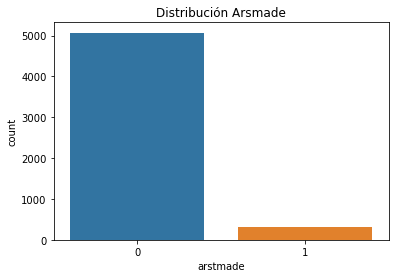

In [63]:
sns.countplot(x='arstmade', data=df_train)
plt.title('Distribución Arsmade')
plt.show()

In [64]:
df_train['arstmade'].value_counts('%')

0    0.940108
1    0.059892
Name: arstmade, dtype: float64

#### Se aumenta la clase minoritaria para que en el global quede una distribucion cercana al 80/20

In [65]:
sm = SMOTE(random_state=42, sampling_strategy=0.3)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [66]:
y_train.value_counts('%')

0    0.769231
1    0.230769
Name: arstmade, dtype: float64

In [67]:
y_train.value_counts()

0    5070
1    1521
Name: arstmade, dtype: int64

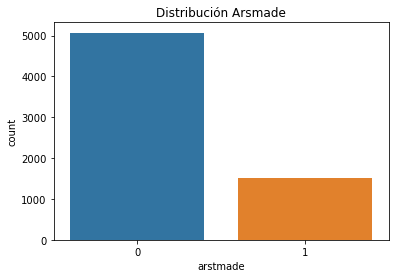

In [68]:
sns.countplot(y_train)
plt.title('Distribución Arsmade')
plt.show()

## UnderSampling

In [69]:
under = RandomUnderSampler(sampling_strategy=0.4, random_state=456)

In [70]:
X_train, y_train = under.fit_resample(X_train, y_train)

In [71]:
y_train.value_counts()

0    3802
1    1521
Name: arstmade, dtype: int64

In [72]:
y_train.value_counts('%')

0    0.714259
1    0.285741
Name: arstmade, dtype: float64

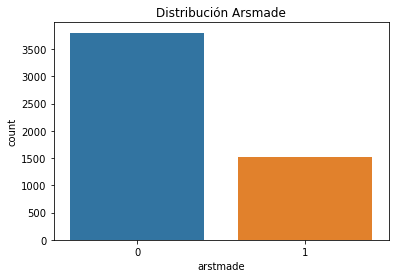

In [73]:
sns.countplot(y_train)
plt.title('Distribución Arsmade')
plt.show()

## Modelación con nuevos valores Train

#### Regresion Logistica

In [74]:
X_train_std = StandardScaler().fit_transform(X_train)
X_test_std = StandardScaler().fit_transform(X_test)

In [75]:
logistic_regresion = LogisticRegression().fit(X_train_std, y_train)

In [76]:
yhat_logistic_regresion_ref = logistic_regresion.predict(X_test_std)

In [77]:
print(classification_report(y_test, yhat_logistic_regresion_ref))

              precision    recall  f1-score   support

           0       0.98      0.78      0.87      5320
           1       0.19      0.73      0.30       377

    accuracy                           0.77      5697
   macro avg       0.58      0.76      0.58      5697
weighted avg       0.92      0.77      0.83      5697



Se obtienen peores valores que los obtenidos en sin oversamplig y undersampling para la clase 1. El modelo identifica caracteristicas de la clase, pero no acierta con las predicciones.

#### Arbol de Clasificación

In [78]:
tree_para = {'max_depth':[50,100,200,250], 'max_features' : [None, 'log2', 'sqrt']}
tree_model_grid_ref = GridSearchCV(DecisionTreeClassifier(), tree_para, cv=5, n_jobs=-1).fit(X_train, y_train)

In [79]:
tree_model_grid_ref.best_params_

{'max_depth': 250, 'max_features': None}

In [80]:
y_hat_tree_model_ref = tree_model_grid_ref.best_estimator_.predict(X_test) 

In [81]:
print(classification_report(y_test, y_hat_tree_model_ref))

              precision    recall  f1-score   support

           0       0.96      0.92      0.94      5320
           1       0.32      0.52      0.40       377

    accuracy                           0.89      5697
   macro avg       0.64      0.72      0.67      5697
weighted avg       0.92      0.89      0.91      5697



Se empeora tambien el rendimiento del modelo comparado con el realizado antes de utilizar oversampling y undersamplig a los datos de entrenamiento. Se nota sobre todo una disminucion en la precision del modelo para la clase 1.

#### AdaBoostClassifier

In [82]:
params_ada={'learning_rate': [0.01, 0.1, 0.5], 'n_estimators': [50,100, 500, 1000, 2000]}
ada_grid_cv_ref = GridSearchCV(AdaBoostClassifier(), params_ada, n_jobs = -1).fit(X_train, y_train)

In [83]:
ada_grid_cv_ref.best_params_

{'learning_rate': 0.1, 'n_estimators': 2000}

In [84]:
y_hat_adaboost_ref = ada_grid_cv_ref.best_estimator_.predict(X_test)

In [85]:
print(classification_report(y_test, y_hat_adaboost_ref))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97      5320
           1       0.67      0.53      0.59       377

    accuracy                           0.95      5697
   macro avg       0.82      0.76      0.78      5697
weighted avg       0.95      0.95      0.95      5697



Comparado con el mismo modelo antes de modificar los datos de entrenamiento, se observa un aumento del recall y una disminución de la precision, quedando cerca de los valores esperados de acuerdo al benchmark.

#### GradientBoostingClassifier

In [86]:
%%time
param_gradient = {'learning_rate': [0.01, 0.1, 0.5],'n_estimators': [50, 100, 500, 1000, 2000], 
                   'subsample': [0.1,0.5,0.9]}
gradient_grid_cv_ref = GridSearchCV(GradientBoostingClassifier(), param_gradient, n_jobs=-1, 
                                cv=5).fit(X_train, y_train)

Wall time: 28min 48s


In [87]:
gradient_grid_cv_ref.best_params_

{'learning_rate': 0.01, 'n_estimators': 2000, 'subsample': 0.5}

In [88]:
y_hat_gradient_boost_ref=gradient_grid_cv_ref.best_estimator_.predict(X_test)

In [89]:
print(classification_report(y_test, y_hat_gradient_boost_ref))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      5320
           1       0.74      0.54      0.63       377

    accuracy                           0.96      5697
   macro avg       0.85      0.76      0.80      5697
weighted avg       0.95      0.96      0.95      5697



- Se logra mejorar el valor de recall del mismo modelo antes del tratamiento de los datos de entrenamiento. Logrando llegar a los valores esperados en el benchmark para los parametros recall y precision.
- El valor de presicion es mayor que el de Recall esto quiere decir que el modelo logra aprender las caracteristicas más marcadas, más cercanas al nucleo de la clase, sin embargo no es capaz de identificar todas las caracteristicas de la clase. Esto debido a que se mantiene un desbalance entre ambas clases.

El modelo con el mejor desempeño de los 4 realizados para este ejercicio es el de GradientBoostingClassifier. 

## Analisis de los atributos más relevante en el modelo realizado con GradientBoost

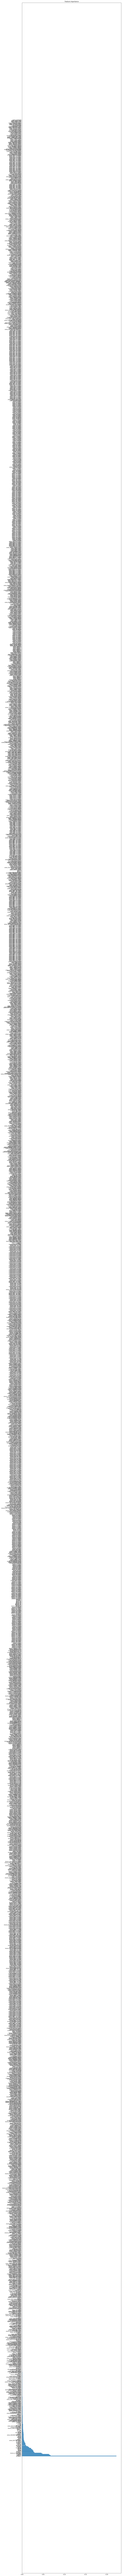

In [90]:
plt.figure(figsize=(15,400))
fn.plot_importance(gradient_grid_cv_ref.best_estimator_, X_train.columns)
plt.yticks(size="xx-large", fontsize=8)
plt.show()

- Cuesta apreciarlo ya que no encontre la forma de separar más las columnas, pero el atributo más importante para el modelo es sb_other_Y (Basis of search - other), seguido por typeofid_P(Stopped person's identification type - Photo).
- Tambien se observa una gran cantidad de datos pertenecientes originalmente a las columnas stname(Location of stop street name) y stinter(Location of stop intersection) que no aportan nada de informacion al modelo, y lo hacen más costoso a nivel computacional.

## Procedimiento policial Violento

A continuación se creará el vector objetivo, en funcion de los atributos que informan como se realizo la detencion.

In [91]:
all_data['pf_hands'].value_counts()

N    8700
Y    2390
Name: pf_hands, dtype: int64

In [92]:
all_data['pf_wall'].value_counts()

N    10696
Y      394
Name: pf_wall, dtype: int64

In [93]:
all_data['pf_grnd'].value_counts()

N    11032
Y       58
Name: pf_grnd, dtype: int64

In [94]:
all_data['pf_drwep'].value_counts()

N    11068
Y       22
Name: pf_drwep, dtype: int64

In [95]:
all_data['pf_ptwep'].value_counts()

N    11054
Y       36
Name: pf_ptwep, dtype: int64

In [96]:
all_data['pf_baton'].value_counts()

N    11085
Y        5
Name: pf_baton, dtype: int64

In [97]:
all_data['pf_hcuff'].value_counts()

N    10686
Y      404
Name: pf_hcuff, dtype: int64

In [98]:
all_data['pf_pepsp'].value_counts()

N    11088
Y        2
Name: pf_pepsp, dtype: int64

In [99]:
all_data['pf_other'].value_counts()

N    11056
Y       34
Name: pf_other, dtype: int64

In [100]:
vio_arstmade = all_data.copy()

In [101]:
attr = ['pf_hands', 'pf_wall', 'pf_grnd', 'pf_drwep', 'pf_ptwep', 'pf_baton', 'pf_hcuff', 'pf_pepsp', 'pf_other']
conditions = (vio_arstmade['pf_hands']=='Y') | (vio_arstmade['pf_wall']=='Y') | (vio_arstmade['pf_grnd']=='Y') | (vio_arstmade['pf_drwep']=='Y') | (vio_arstmade['pf_ptwep']=='Y') | (vio_arstmade['pf_baton']=='Y') | (vio_arstmade['pf_hcuff']=='Y') | (vio_arstmade['pf_pepsp']=='Y') | (vio_arstmade['pf_other']=='Y')
vio_arstmade['violence_arstmade']= np.where(conditions, 1, 0)

In [102]:
vio_arstmade['violence_arstmade'].value_counts()

0    8370
1    2720
Name: violence_arstmade, dtype: int64

In [103]:
vio_arstmade['violence_arstmade'].value_counts('%')

0    0.754734
1    0.245266
Name: violence_arstmade, dtype: float64

In [104]:
vio_arstmade.loc[:, attr][vio_arstmade['pf_hands']=='Y']

pf_hands pf_wall pf_grnd pf_drwep pf_ptwep pf_baton pf_hcuff pf_pepsp  \
8            Y       N       N        N        N        N        N        N   
13           Y       N       N        N        N        N        N        N   
21           Y       N       N        N        N        N        N        N   
23           Y       N       N        N        N        N        N        N   
24           Y       N       N        N        N        N        Y        N   
...        ...     ...     ...      ...      ...      ...      ...      ...   
11069        Y       N       N        N        N        N        N        N   
11073        Y       N       N        N        N        N        N        N   
11075        Y       N       N        N        N        N        N        N   
11085        Y       N       N        N        N        N        N        N   
11088        Y       N       N        N        N        N        N        N   

      pf_other  
8            N  
13           N  
21           N  
23           N  
24           N  
...        ...  
11069        N  
11073        N  
11075        N  
11085        N  
11088        N  

[2390 rows x 9 columns]

In [105]:
vio_arstmade = vio_arstmade.drop(attr, axis=1)

In [106]:
vio_arstmade = vio_arstmade.drop('arstmade', axis=1)

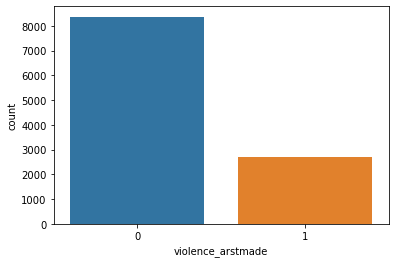

In [107]:
sns.countplot(vio_arstmade['violence_arstmade'])
plt.show()

In [108]:
vio_arstmade = fn.binarizacion(vio_arstmade)

In [109]:
vi_train = vio_arstmade[vio_arstmade['year']==2009].drop(['year'], axis=1)
vi_test = vio_arstmade[vio_arstmade['year']==2010].drop(['year'], axis=1)

### Definicion del conjunto de Train y Test

In [110]:
X_train_vi = vi_train.drop('violence_arstmade', axis=1)
y_train_vi = vi_train['violence_arstmade']
X_test_vi = vi_test.drop('violence_arstmade', axis=1)
y_test_vi = vi_test['violence_arstmade']

In [111]:
X_train_vi_std = StandardScaler().fit_transform(X_train_vi)
X_test_vi_std = StandardScaler().fit_transform(X_test_vi)

## Modelos para predicir si el procedimiento policial terminara de manera violenta.

### Regresion Logistica

In [112]:
lr = LogisticRegression().fit(X_train_vi_std, y_train_vi)

In [113]:
yhat_lr_vi= lr.predict(X_test_vi_std)

In [114]:
print(classification_report(y_test_vi, yhat_lr_vi))

              precision    recall  f1-score   support

           0       0.79      0.89      0.84      4313
           1       0.44      0.28      0.34      1384

    accuracy                           0.74      5697
   macro avg       0.62      0.58      0.59      5697
weighted avg       0.71      0.74      0.72      5697



En la clase 0 se observan valores aceptables de los parametros. 
En la clase 1, se observan bajos resultados en los parametros, aunque cercanos al benchmark. La precision es mas alta que el recall lo que indica que el modelo identifica las caracteristicas más marcadas de la clase 1, pero no es capaz de identificarlas todas.

### Arbol de clasificacion

In [115]:
tree_para = {'max_depth':[50,100,200,250], 'max_features' : [None, 'log2', 'sqrt']}
tree_model_grid_vi = GridSearchCV(DecisionTreeClassifier(), tree_para, cv=5, n_jobs=-1).fit(X_train_vi, 
                                                                                             y_train_vi)

In [116]:
tree_model_grid_vi.best_params_

{'max_depth': 50, 'max_features': None}

In [117]:
y_hat_tree_model_vi = tree_model_grid_vi.best_estimator_.predict(X_test_vi) 

In [118]:
print(classification_report(y_test_vi, y_hat_tree_model_vi))

              precision    recall  f1-score   support

           0       0.82      0.83      0.82      4313
           1       0.44      0.42      0.43      1384

    accuracy                           0.73      5697
   macro avg       0.63      0.62      0.63      5697
weighted avg       0.72      0.73      0.73      5697



En la clase 1 se mejoran los valores obtenidos para recall con respecto a la regresion logistica, pero no asi la precision. Por lo que aun no es suficiente para superar el benchmark.

### Análisis Cuadrático Discriminante

In [119]:
qda_model = QuadraticDiscriminantAnalysis().fit(X_train_vi_std, y_train_vi)

In [120]:
y_hat_qda = qda_model.predict(X_test_vi_std)

In [121]:
print(classification_report(y_test_vi, y_hat_qda))

              precision    recall  f1-score   support

           0       0.81      0.04      0.08      4313
           1       0.24      0.97      0.39      1384

    accuracy                           0.27      5697
   macro avg       0.53      0.51      0.23      5697
weighted avg       0.67      0.27      0.15      5697



Se obtienen valores muy malos, para la clase 0 el recall es de 0,04 y precision de 0,81 lo que indica que el modelo es capaz de reconocer muy pocas caracteristicas de la clase 1.
Para la clase 0 es al revez, es capaz de identificar a la mayoria de los elementos de la clase 1, pero acierta muy poco con las prediciones.

### AdaBoostClassifier

In [122]:
params_ada={'learning_rate': [0.01, 0.1, 0.5], 'n_estimators': [50,100, 500, 1000, 2000]}
ada_grid_cv_vi = GridSearchCV(AdaBoostClassifier(), params_ada, n_jobs = -1).fit(X_train_vi, y_train_vi)

In [123]:
ada_grid_cv_vi.best_params_

{'learning_rate': 0.5, 'n_estimators': 100}

In [124]:
y_hat_adaboost_vi = ada_grid_cv_vi.best_estimator_.predict(X_test_vi)

In [132]:
print(classification_report(y_test_vi, y_hat_adaboost_vi))

              precision    recall  f1-score   support

           0       0.80      0.93      0.86      4313
           1       0.54      0.28      0.37      1384

    accuracy                           0.77      5697
   macro avg       0.67      0.60      0.61      5697
weighted avg       0.74      0.77      0.74      5697



Para la clase 1 se logran obtener valores cercanos a los esperados de acuerdo al benchmark.

### GradientBoostingClassifier

In [126]:
%%time
param_gradient = {'learning_rate': [0.01, 0.1, 0.5],'n_estimators': [50, 100, 500, 1000, 2000], 
                   'subsample': [0.1,0.5,0.9]}
gradient_grid_cv_vi = GridSearchCV(GradientBoostingClassifier(), param_gradient, n_jobs=-1, 
                                cv=5).fit(X_train_vi, y_train_vi)

Wall time: 29min 44s


In [127]:
gradient_grid_cv_vi.best_params_

{'learning_rate': 0.1, 'n_estimators': 1000, 'subsample': 0.5}

In [128]:
y_hat_gboost_vi = gradient_grid_cv_vi.best_estimator_.predict(X_test_vi)

In [129]:
print(classification_report(y_test_vi, y_hat_gboost_vi))

              precision    recall  f1-score   support

           0       0.82      0.90      0.86      4313
           1       0.55      0.37      0.44      1384

    accuracy                           0.77      5697
   macro avg       0.68      0.64      0.65      5697
weighted avg       0.75      0.77      0.76      5697



- Se mejora el desempeño del modelo comparado con el modelo anterior, y se logran superar los valores del benchmark para recall y precision en la clase 1.
- Se observa que el valor de precision es mayor que el de recall lo que quiere decir que el modelo logra identificar correctamente las caracteristicas principales de la clase, pero no todas las caracteristicas de esta. Esto se puede explicar debido al desvanlance entre las clases.
- Probablemente si hubiese realizado un trabajo de oversampling y/o undersampling como el el ejercicio de predecir si una detencion terminaria en arresto, podria haber logrado un mejor desempeño del modelo.

### Serializacion de los 2 mejores Modelos

El modelo con el mejor desempeño es GradientBoostingClassifier

In [134]:
dump(gradient_grid_cv_vi.best_params_, 'gradient_boost_model.pkl')

['gradient_boost_model.pkl']

El segundo modelo con el mejor desempeño es AdaBoostClassifier

In [135]:
dump(ada_grid_cv_vi.best_params_, 'adaboost_model.pkl')

['adaboost_model.pkl']